# SFML Project

Ward Gauderis - 0588485
Fabian Denoodt - TODO

Master Computer Science in Artificial Intelligence - Vrije Universiteit Brussel

## Introduction

1. What is the influence of noise in the training data on the in- and out-of-sample error and how does regularization counter this?
2. b
3. c

#### Initialization

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
from sklearn.datasets import make_circles
from sklearn.neural_network import MLPClassifier


# plt.style.use('dark_background')

def plot_decision_boundaries(X, y, model_class, **model_params):
    model = model_class(**model_params)
    model.fit(X, y)

    h = 0.02

    length_x = X[:, 0].max() - X[:, 0].min()
    length_y = X[:, 1].max() - X[:, 1].min()
    x_min, x_max = X[:, 0].min() - length_x / 10, X[:, 0].max() + length_x / 10
    y_min, y_max = X[:, 1].min() - length_y / 10, X[:, 1].max() + length_y / 10

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    plt.xlabel("Feature-1", fontsize=15)
    plt.ylabel("Feature-2", fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    return plt

## Research Question 1

Data noise & label noise

Iteration 1, loss = 0.70106368
Iteration 2, loss = 0.69956240
Iteration 3, loss = 0.69814958
Iteration 4, loss = 0.69691076
Iteration 5, loss = 0.69571076
Iteration 6, loss = 0.69453590
Iteration 7, loss = 0.69342804
Iteration 8, loss = 0.69230559
Iteration 9, loss = 0.69154851
Iteration 10, loss = 0.69038958
Iteration 11, loss = 0.68941761
Iteration 12, loss = 0.68854880
Iteration 13, loss = 0.68766431
Iteration 14, loss = 0.68693298
Iteration 15, loss = 0.68596221
Iteration 16, loss = 0.68517328
Iteration 17, loss = 0.68436620
Iteration 18, loss = 0.68356302
Iteration 19, loss = 0.68279664
Iteration 20, loss = 0.68202786
Iteration 21, loss = 0.68125006
Iteration 22, loss = 0.68050473
Iteration 23, loss = 0.67972761
Iteration 24, loss = 0.67896963
Iteration 25, loss = 0.67816731
Iteration 26, loss = 0.67745538
Iteration 27, loss = 0.67669083
Iteration 28, loss = 0.67590011
Iteration 29, loss = 0.67518428
Iteration 30, loss = 0.67443091
Iteration 31, loss = 0.67361207
Iteration 32, los

<module 'matplotlib.pyplot' from '/usr/lib/python3.10/site-packages/matplotlib/pyplot.py'>

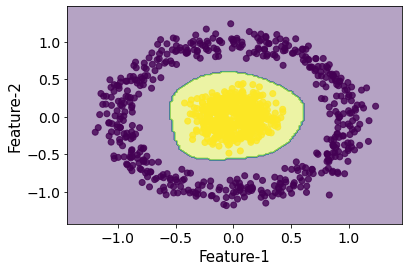

In [40]:
X, y = make_circles(n_samples=1000, noise=0.1, factor=0.2)

plot_decision_boundaries(X, y, MLPClassifier, activation="tanh", solver="adam", hidden_layer_sizes=(10,),
                         max_iter=10000, random_state=0, verbose=True)

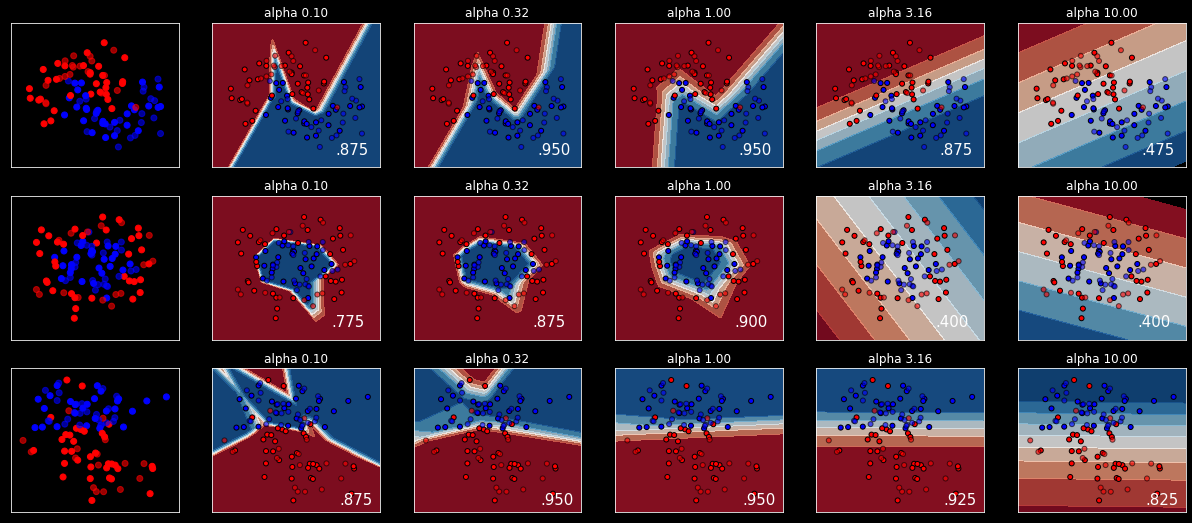

In [48]:
# Author: Issam H. Laradji
# License: BSD 3 clause

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline

h = 0.02  # step size in the mesh

alphas = np.logspace(-1, 1, 5)

classifiers = []
names = []
for alpha in alphas:
    classifiers.append(
        make_pipeline(
            StandardScaler(),
            MLPClassifier(
                solver="lbfgs",
                alpha=alpha,
                random_state=1,
                max_iter=2000,
                early_stopping=True,
                hidden_layer_sizes=[10, 10],
            ),
        )
    )
    names.append(f"alpha {alpha:.2f}")

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=0, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(17, 9))
i = 1
# iterate over datasets
for X, y in datasets:
    # split into training and test part
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)


        Z = clf.predict_proba(np.column_stack([xx.ravel(), yy.ravel()]))[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

        # Plot also the training points
        ax.scatter(
            X_train[:, 0],
            X_train[:, 1],
            c=y_train,
            cmap=cm_bright,
            edgecolors="black",
            s=25,
        )
        # and testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            alpha=0.6,
            edgecolors="black",
            s=25,
        )

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name)
        ax.text(
            xx.max() - 0.3,
            yy.min() + 0.3,
            f"{score:.3f}".lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

figure.subplots_adjust(left=0.02, right=0.98)
plt.show()

## Research Question 2

## Research Question 3

## Conclusion